In [79]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
from itertools import product
from os import listdir

import importlib

import compare_rates
importlib.reload(compare_rates)

<module 'compare_rates' from '/Users/kelley/Projects/FamilySeqError/parameter_estimation/compare_rates.py'>

In [80]:
chroms = [str(i) for i in range(1, 23)]

gens = ['0/0', '0/1', '1/1']
obss = ['0/0', '0/1', '1/1', './.']

# First, check twins

In [81]:
ihart_samples = compare_rates.pull_samples('../../DATA/ihart.ms2/family_genotype_counts/identicals', chroms)
spark_exome_samples = compare_rates.pull_samples('../../DATA/spark.exome/family_genotype_counts/EX_identicals', chroms)
spark_samples = compare_rates.pull_samples('../../DATA/spark/family_genotype_counts/identicals', chroms)


1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 
Removing 0 individuals involved in multiple generations
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 
Removing 0 individuals involved in multiple generations
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 
Removing 0 individuals involved in multiple generations


In [82]:
ihart_error_rates = compare_rates.pull_error_rates(ihart_samples, '../params/ihart.ms2_identicals_params.json', gens, obss)
spark_exome_error_rates = compare_rates.pull_error_rates(spark_exome_samples, '../params/spark.exome_EX_identicals_params.json', gens, obss)
spark_error_rates = compare_rates.pull_error_rates(spark_samples, '../params/spark_identicals_params.json', gens, obss)

ihart_error_counts = compare_rates.pull_error_counts(ihart_samples, '../params/ihart.ms2_identicals_params.json', gens, obss)
spark_exome_error_counts = compare_rates.pull_error_counts(spark_exome_samples, '../params/spark.exome_EX_identicals_params.json', gens, obss)
spark_error_counts = compare_rates.pull_error_counts(spark_samples, '../params/spark_identicals_params.json', gens, obss)



In [84]:
def pull_twins(twin_file, data_dir, samples, exclude_lcl=True):
    twin_pairs = []
    with open(twin_file, 'r') as f:
        for line in f:
            individuals = [x.split('_')[-1] if exclude_lcl else x for x in line.strip().split('\t') if (not exclude_lcl) or ('LCL' not in x)]
            individuals = [x for x in individuals if x in samples.sample_ids]
            if len(individuals) == 2:
                twin_pairs.append(tuple(individuals))
                
    # twin1, twin2
    counts = np.zeros((len(twin_pairs), 4, 4), dtype=int)
    
    famkeys = [None for _ in twin_pairs]
    for i, chrom in enumerate(chroms):
        print(chrom, end=' ')

        count_files = sorted([f for f in listdir(data_dir) if ('chr.%s.' % chrom) in f and 'famgen.counts.txt' in f])
        for count_file in count_files:
            with open('%s/%s' % (data_dir, count_file), 'r') as f:
                for line in f:
                    pieces = line.strip().split('\t')
                    fk, inds = pieces[:2]
                    inds = inds.split('.')

                    for twinpair_index, (twin1, twin2) in enumerate(twin_pairs):
                        if twin1 in inds and twin2 in inds:
                            famkeys[twinpair_index] = fk
                            ind_to_index = dict([(x, i) for i, x in enumerate(inds)])

                            for g, c in zip(product([0, 1, 2, 3], repeat=len(inds)), pieces[2:]):
                                counts[twinpair_index, g[ind_to_index[twin1]], g[ind_to_index[twin2]]] += int(c)
    return twin_pairs, counts

ihart_twins, ihart_twin_counts = pull_twins('../../PhasingFamilies/sibpair_similarity/ihart_identicals.txt', '../../DATA/ihart.ms2/family_genotype_counts', ihart_samples)
spark_exome_twins, spark_exome_twin_counts = pull_twins('../../PhasingFamilies/sibpair_similarity/spark_exome_identicals.txt', '../../DATA/spark.exome/family_genotype_counts/EX', spark_exome_samples)
spark_twins, spark_twin_counts = pull_twins('../../PhasingFamilies/sibpair_similarity/spark_identicals.txt', '../../DATA/spark/family_genotype_counts', spark_samples)


1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 

In [85]:
mismatches = [('0/0', '0/1'), ('0/0', '1/1'), ('0/1', '1/1'),
             ('0/0', './.'), ('0/1', './.'), ('1/1', './.')]

def twin_expected_vs_observed(twins, samples, error_counts, twin_counts, error_rates):
    print(mismatches)
    # first expected
    expected = np.zeros((2*len(twins), len(mismatches)))
    observed = np.zeros((2*len(twins), len(mismatches)))
    famsize = np.zeros((2*len(twins),))
    
    for i, (twin1, twin2) in enumerate(twins):
        twin1_index, twin2_index = samples.sample_ids.index(twin1), samples.sample_ids.index(twin2)
        for j, (obs1, obs2) in enumerate(mismatches):
            
            # expected
            obs1_index, obs2_index = obss.index(obs1), obss.index(obs2)
            # obs1 is correct, obs2 is the error
            if obs1 in gens:
                expected[2*i, j] = error_counts[twin2_index, obs1_index, obs2_index]
                expected[(2*i)+1, j] = error_counts[twin1_index, obs1_index, obs2_index]
            # obs2 is correct, obs1 is the error
            if obs2 in gens:
                expected[2*i, j] += error_counts[twin1_index, obs2_index, obs1_index]
                expected[(2*i)+1, j] += error_counts[twin2_index, obs2_index, obs1_index]
    
            # observed
            observed[2*i, j] = twin_counts[i, obs1_index, obs2_index]
            observed[(2*i)+1, j] = twin_counts[i, obs2_index, obs1_index]
            
        famsize[2*i] = samples.family_sizes[twin1_index]
        famsize[(2*i) + 1] = samples.family_sizes[twin2_index]
        
        assert samples.family_sizes[twin1_index] == samples.family_sizes[twin2_index]
    
    return expected, observed, famsize

ihart_twins_expected, ihart_twins_observed, ihart_twins_famsize = twin_expected_vs_observed(ihart_twins, ihart_samples, ihart_error_counts, ihart_twin_counts, ihart_error_rates)
spark_exome_twins_expected, spark_exome_twins_observed, spark_exome_twins_famsize = twin_expected_vs_observed(spark_exome_twins, spark_exome_samples, spark_exome_error_counts, spark_exome_twin_counts, spark_exome_error_rates)
spark_twins_expected, spark_twins_observed, spark_twins_famsize = twin_expected_vs_observed(spark_twins, spark_samples, spark_error_counts, spark_twin_counts, spark_error_rates)



[('0/0', '0/1'), ('0/0', '1/1'), ('0/1', '1/1'), ('0/0', './.'), ('0/1', './.'), ('1/1', './.')]
[('0/0', '0/1'), ('0/0', '1/1'), ('0/1', '1/1'), ('0/0', './.'), ('0/1', './.'), ('1/1', './.')]
[('0/0', '0/1'), ('0/0', '1/1'), ('0/1', '1/1'), ('0/0', './.'), ('0/1', './.'), ('1/1', './.')]


//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:18: RuntimeWarning: divide by zero encountered in log10
//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:13: RuntimeWarning: divide by zero encountered in log10
//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:17: RuntimeWarning: divide by zero encountered in log10
//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:14: RuntimeWarning: divide by zero encountered in log10
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


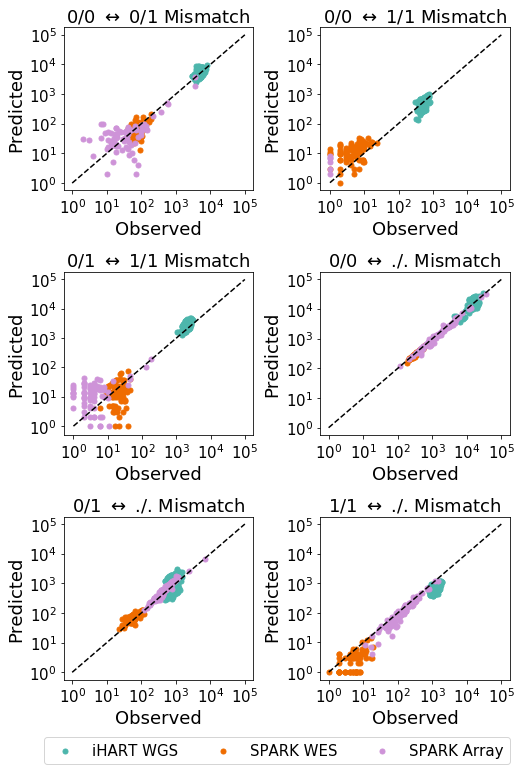

In [86]:
plt.rcParams.update({'font.size': 20})


fig = plt.figure(figsize=(8, 12))
for i, (obs1, obs2) in enumerate(mismatches):
    plt.subplot(3, 2, i+1)
    plt.title(r'%s $\leftrightarrow$ %s Mismatch' % (obs1, obs2), fontsize=18)
    
    plt.scatter(np.log10(np.round(ihart_twins_observed[:, i])), 
                np.log10(np.round(ihart_twins_expected[:, i])),
                color='#4db6ac', label='iHART WGS', marker='.', s=100)
    
    plt.scatter(np.log10(np.round(spark_exome_twins_observed[:, i])), 
                np.log10(np.round(spark_exome_twins_expected[:, i])),
                color='#ef6c00', label='SPARK WES', marker='.', s=100)
    
    plt.scatter(np.log10(np.round(spark_twins_observed[:, i])), 
                np.log10(np.round(spark_twins_expected[:, i])),
                color='#ce93d8ff', label='SPARK Array', marker='.', s=100)

    plt.plot([0, 5], [0, 5], color='black', linestyle='--')
    plt.xticks(range(6), ['$10^%d$' % d for d in range(6)], fontsize=15)
    plt.yticks(range(6), ['$10^%d$' % d for d in range(56)], fontsize=15)
    plt.xlabel('Observed', fontsize=18)
    plt.ylabel('Predicted', fontsize=18)
    
    if i==5:
        plt.legend(fontsize=15, bbox_to_anchor=(1, -0.35), borderaxespad=0., ncol=3)
        
        
#plt.tight_layout()
fig.subplots_adjust(hspace=0.5, wspace=0.35)
plt.savefig('../plots/mismatches.eps')
#plt.show()



# Compare LCL vs WB

In [87]:
ihart_lcl_samples = compare_rates.pull_samples('../../DATA/ihart.ms2/family_genotype_counts/lcls', chroms)


1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 
Removing 0 individuals involved in multiple generations


In [88]:
ihart_lcl_error_rates = compare_rates.pull_error_rates(ihart_lcl_samples, '../params/ihart.ms2_lcls_params.json', gens, obss)
ihart_lcl_error_counts = compare_rates.pull_error_counts(ihart_lcl_samples, '../params/ihart.ms2_lcls_params.json', gens, obss)



In [89]:
ihart_lcls, ihart_lcl_counts = pull_twins('../data/ihart.ms2_lcls.txt', '../../DATA/ihart.ms2/family_genotype_counts', ihart_lcl_samples, exclude_lcl=False)


1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 

In [90]:
print(ihart_lcls)

[('AU1043304_LCL', 'AU1043304'), ('AU2911309_LCL', 'AU2911309'), ('AU1860301_LCL', 'AU1860301'), ('AU3154301_LCL', 'AU3154301'), ('AU3053301_LCL', 'AU3053301'), ('AU3646301_LCL', 'AU3646301'), ('AU3846302_LCL', 'AU3846302'), ('AU3702307_LCL', 'AU3702307'), ('AU3761302_LCL', 'AU3761302'), ('AU3913302_LCL', 'AU3913302'), ('AU3713302_LCL', 'AU3713302'), ('AU3051303_LCL', 'AU3051303'), ('AU3839303_LCL', 'AU3839303'), ('AU4032306_LCL', 'AU4032306'), ('AU2410302_LCL', 'AU2410302'), ('AU1308303_LCL', 'AU1308303'), ('AU4235303_LCL', 'AU4235303')]


In [91]:
ihart_lcls_expected, ihart_lcls_observed, ihart_lcls_famsize = twin_expected_vs_observed(ihart_lcls, ihart_lcl_samples, ihart_lcl_error_counts, ihart_lcl_counts, ihart_lcl_error_rates)


[('0/0', '0/1'), ('0/0', '1/1'), ('0/1', '1/1'), ('0/0', './.'), ('0/1', './.'), ('1/1', './.')]


In [92]:
print(ihart_lcls_expected)

[[ 1771.8959656    196.48538332  1053.65490026  7803.47277074
    417.31034569   444.97916397]
 [ 3812.54563673  1291.50928388   871.16447755  6445.56259602
    126.28331766   281.8209343 ]
 [ 3245.9794498    277.82378869  1470.21638719  4919.45269381
    633.39953143   409.94984545]
 [ 6465.14016704  1721.46590137   985.10647227  3667.35156007
    196.90408474   226.07912688]
 [ 2812.31365418   172.29952267  1697.28804282 11925.42221805
    549.7495122    611.20443377]
 [ 5390.13652325  1367.00504715  1438.07079499 10227.57998652
    145.58284917   326.46992831]
 [ 4004.60991347   271.78206162  2716.76261646 12934.7573084
   1077.17015743   915.60050313]
 [ 8239.09883142  2050.9137834   2058.66991244 11555.91550238
    403.58998065   468.90981007]
 [ 1849.14801971   191.10788212  1453.36725364  9979.36201491
    614.25440621   517.01601723]
 [ 4241.4267575   1188.96562536  1178.59209049  8707.61582749
    153.56295643   296.22501702]
 [ 2704.27992755   212.92354746  1406.70959842  576

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


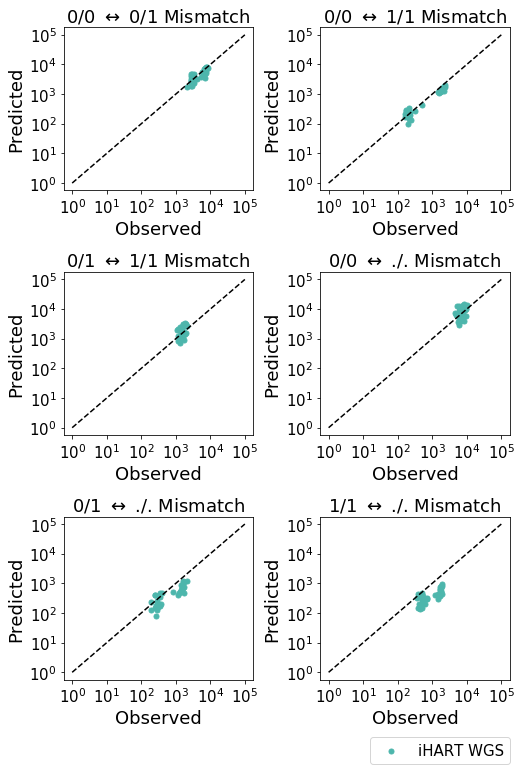

In [93]:
plt.rcParams.update({'font.size': 20})


fig = plt.figure(figsize=(8, 12))
for i, (obs1, obs2) in enumerate(mismatches):
    plt.subplot(3, 2, i+1)
    plt.title(r'%s $\leftrightarrow$ %s Mismatch' % (obs1, obs2), fontsize=18)
    
    plt.scatter(np.log10(np.round(ihart_lcls_observed[:, i])), 
                np.log10(np.round(ihart_lcls_expected[:, i])),
                color='#4db6ac', label='iHART WGS', marker='.', s=100)

    plt.plot([0, 5], [0, 5], color='black', linestyle='--')
    plt.xticks(range(6), ['$10^%d$' % d for d in range(6)], fontsize=15)
    plt.yticks(range(6), ['$10^%d$' % d for d in range(56)], fontsize=15)
    plt.xlabel('Observed', fontsize=18)
    plt.ylabel('Predicted', fontsize=18)
    
    if i==5:
        plt.legend(fontsize=15, bbox_to_anchor=(1, -0.35), borderaxespad=0., ncol=3)
        
        
#plt.tight_layout()
fig.subplots_adjust(hspace=0.5, wspace=0.35)
plt.savefig('../plots/mismatches.eps')
#plt.show()

